In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs

np.random.seed(37)

def corr(xi, xj, theta, ph):
    return np.exp(-theta * (np.abs(xi - xj)**ph))

def corr_matrix(X, theta, ph):
    n = X.shape[0]
    R = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            R[i, j] = corr(X[i], X[j], theta, ph)
    R += np.eye(n) * 1e-8  # Ensure positive definiteness
    return R

def neg_log_likelihood(params, X, y):
    theta, ph = params
    try:
        R = corr_matrix(X, theta, ph)
        L = np.linalg.cholesky(R)
        L_inv = np.linalg.inv(L)
        R_inv = np.dot(L_inv.T, L_inv)
        ones = np.ones(len(y))
        mu = np.dot(ones.T, np.dot(R_inv, y)) / np.dot(ones.T, np.dot(R_inv, ones))
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y - mu))
        term1 = np.dot(y - mu, alpha)
        sigma2 = term1 / len(y)
        log_likelihood = -0.5 * len(y) * np.log(2 * np.pi * sigma2) - 0.5 * np.log(np.linalg.det(R)) - 0.5 * term1 / sigma2
        return -log_likelihood
    except np.linalg.LinAlgError:
        return np.inf

def compute_sigma2_mu(params, X, y):
    theta,ph = params
    R = corr_matrix(X, theta, ph)
    L = np.linalg.cholesky(R)
    L_inv = np.linalg.inv(L)
    R_inv = np.dot(L_inv.T, L_inv)
    ones = np.ones(len(y))
    mu = np.dot(ones.T, np.dot(R_inv,y)) / np.dot(ones.T, np.dot(R_inv, ones))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y - mu))
    term1 = np.dot(y - mu, alpha)
    sigma2 = term1 / len(y)
    return sigma2, mu

def kriging_parameters(X, y):
    initial_guess = [1.0, 2]  # Initial guess for theta and ph
    bounds = [(0, 5), (1, 2)]
    res = minimize(neg_log_likelihood, initial_guess, args=(X, y), bounds=bounds)
    return res.x

data = pd.read_csv('E:/DUMP/Ashfaq.csv')
X_sample = data['X'].values.reshape(-1, 1)
y_sample = data['y'].values

# Fit Kriging model
theta, ph = kriging_parameters(X_sample, y_sample)
sigma2, mu = compute_sigma2_mu([theta, ph], X_sample, y_sample)




In [2]:
print(theta, ph, sigma2, mu)
print(X_sample.shape, y_sample.shape)

5.0 1.0 15.293132309144438 4.123711214096895
(27, 1) (27,)


In [7]:
# Predict
x_grid = np.linspace(5, 10, 1000)
X_grid = x_grid.reshape(-1, 1)

R = corr_matrix(X_sample, theta, ph)
L = np.linalg.cholesky(R)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_sample - mu))

# Compute correlations for new points
R_star = np.zeros((len(X_grid), len(X_sample)))
for i in range(len(X_grid)):
    for j in range(len(X_sample)):
        R_star[i, j] = corr(X_grid[i], X_sample[j], theta, ph)

# Equation (7)
mu_star = mu + np.dot(R_star, alpha) # Mean for each prediction point

print(mu_star)



[ 2.06921422  2.01715166  1.9637698   1.9090352   1.85291358  1.7953698
  1.73636782  1.67587067  1.66837977  1.68828678  1.70666851  1.72353649
  1.73890128  1.7527725   1.76515883  1.77606804  1.78550696  1.7934815
  1.79999664  1.80505649  1.80866419  1.81082202  1.81153132  1.81079254
  1.80860521  1.80496797  1.79987853  1.79333372  1.78532942  1.77586063
  1.76492142  1.75250494  1.7386034   1.72320811  1.70630942  1.69368716
  1.69769357  1.73407884  1.76896752  1.80238146  1.83434158  1.86486791
  1.89397956  1.92169477  1.94803088  1.9730044   1.99663097  2.01892538
  2.03990159  2.05957275  2.07795116  2.09504835  2.11087502  2.12544108
  2.13875566  2.15082709  2.16166293  2.17126997  2.17965423  2.18682095
  2.19277463  2.197519    2.20105702  2.20339091  2.20452213  2.2044514
  2.20317866  2.20070312  2.19702324  2.19213669  2.18604044  2.17873065
  2.17020274  2.16045139  2.14947048  2.13725313  2.12379169  2.10907773
  2.09310204  2.07585461  2.05732464  2.03750052  2.01

In [8]:

# Compute variance (Mean Squared Error) using Equation (9)
L = np.linalg.cholesky(R)
L_inv = np.linalg.inv(L)
R_inv = np.dot(L_inv.T, L_inv)
#print(R_inv)
s2_star = np.zeros(len(X_grid))
one = np.ones((len(X_sample), 1)) 

for i in range(len(X_grid)):
    r = R_star[i, :].reshape(-1, 1)  # column vector r for the ith new point
    term1 = np.dot(np.dot(r.T, R_inv), r)
    term2_part1 = np.dot(np.dot(one.T, R_inv), r)
    term2 = (term2_part1 - 1) ** 2 / np.dot(one.T, np.dot(R_inv, one))
    s2_star[i] = sigma2 * (1 - term1 + term2)
    print(s2_star[i])

#print(s2_star)   

#sigma_star = np.sqrt(s2_star)
sigma_star = s2_star


4.751027792488293
4.196864185062618
3.616034698138972
3.007215741295928
2.3690169329102306
1.6999777010823556
0.9985637108410192
0.2631631087296066
0.48647893844779505
1.179150845821879
1.8105058923464652
2.3820838307084364
2.8952783800871216
3.3513406941190462
3.7513824739877157
4.096378734424432
4.387170229538507
4.624465544544154
4.80884285861553
4.940751383278974
5.020512479940363
5.0483204593418005
5.024243064947908
4.948221641470309
4.820070988951591
4.639478902044293
4.406005393332393
4.119081598752574
3.77800836237807
3.381954497025283
2.9299547163327815
2.420907233141039
1.8535710181654155
1.2265627121064402
0.5383531834748053
0.16201685340927705
0.059540878300176986
0.8005766470104974
1.5006705884711145
2.1614919414844325
2.784615248149134
3.3715242480907506
3.923615547470089
4.442202071932309
4.928516312119478
5.383713369850247
5.8088738125728305
6.20500634321858
6.57305029212183
6.9138779372274906
7.22829665837869
7.517050931063209
7.780824164594634
8.02024038931818
8.23586

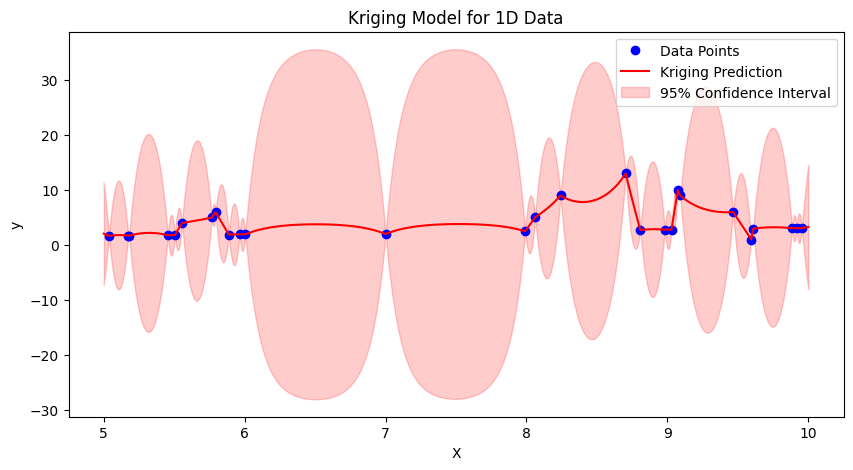

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(X_sample, y_sample, 'bo', label='Data Points')
plt.plot(x_grid, mu_star, 'r-', label='Kriging Prediction')
plt.fill_between(x_grid, mu_star - 1.96 * sigma_star, mu_star + 1.96 * sigma_star, color='r', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Kriging Model for 1D Data')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Expected Improvement')

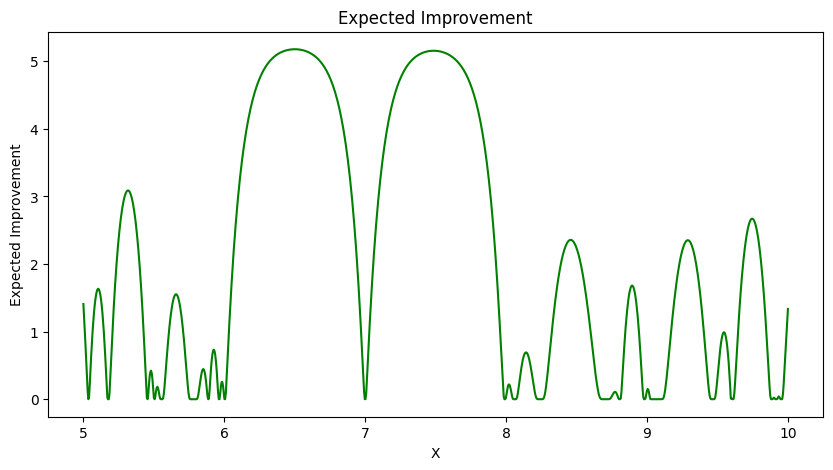

In [11]:
# Expected Improvement
f_min = np.min(y_sample)
err = f_min - mu_star
gamma = err / sigma_star
ei = err * norm.cdf(gamma) + sigma_star * norm.pdf(gamma)

# Plot Expected Improvement
plt.figure(figsize=(10, 5))
plt.plot(x_grid, ei, 'g-')
plt.xlabel('X')
plt.ylabel('Expected Improvement')
plt.title('Expected Improvement')

